I recently came across an interesting problem where I needed to find squares in a image, its a simple problem which I solved with a bit of 
computer vision algorithms and mathematics. lets give it a try

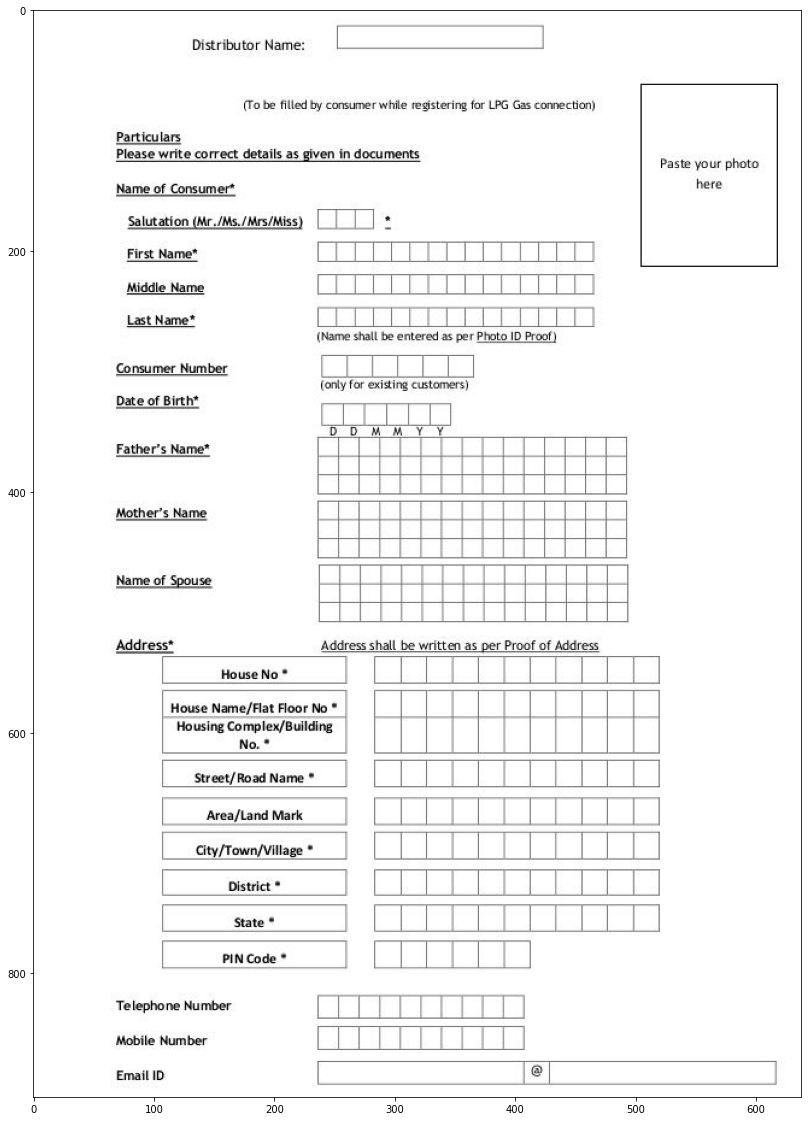

In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

# lets load our sample image
img =  imread('resources/gas_form.jpg')
plt.figure(figsize=(20,20))
plt.imshow(img)

There are many recatangles and squares in this image, this is a simple image to get started. We will try on more complicated images later and see what can be done there 

Here is a high level outline of the algorithm
1. Load the image, turn it into grayscale
2. find contours
3. polygon approximate the contours.
4. isolate contours with 4 points
5. isolate contours which may be squares (need to figure this out)

## 2. Find contours

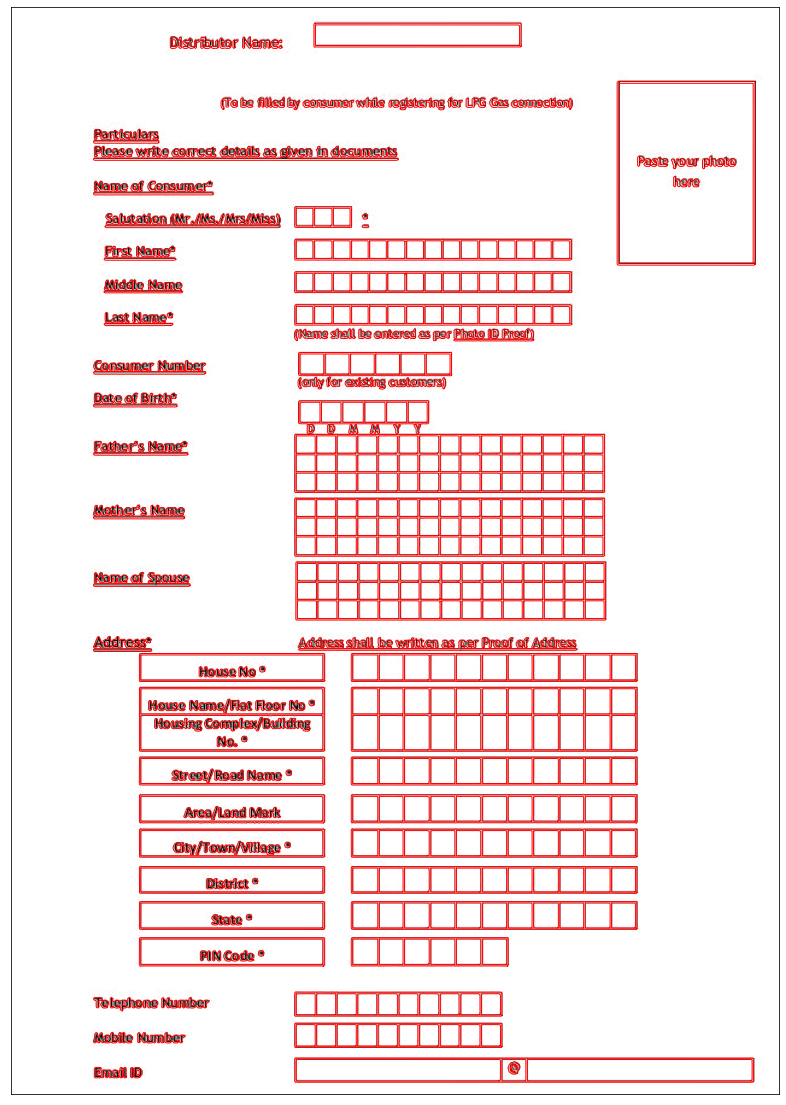

In [6]:
from skimage import measure


gray = rgb2gray(img)

contours = measure.find_contours(gray, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(gray, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0],'-r', linewidth=1)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## 3. Polygon approximate the contours.

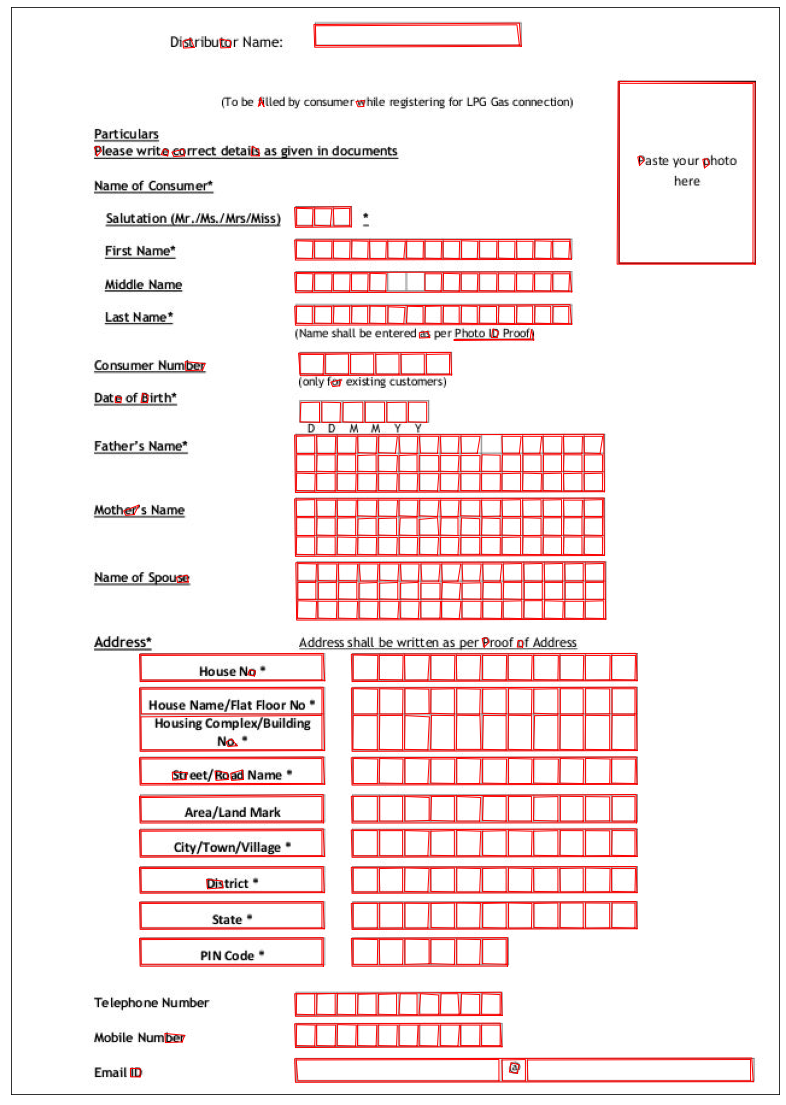

In [5]:
from skimage.measure import approximate_polygon

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(gray, cmap=plt.cm.gray)

for contour in contours:
    coords = approximate_polygon(contour, tolerance=2.5)
    ax.plot(coords[:, 1], coords[:, 0], '-r', linewidth=1)
        
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()


### 4. isolate contours with 4 points

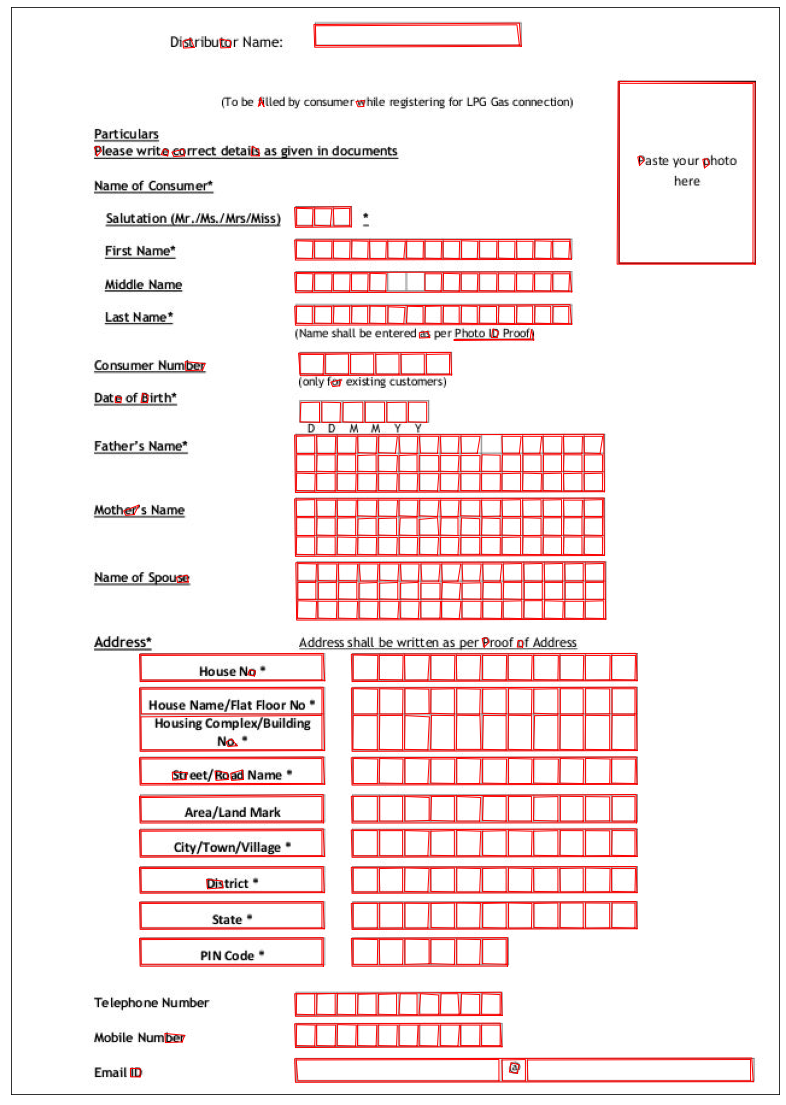

In [16]:
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(gray, cmap=plt.cm.gray)

potential_squares = []

for contour in contours:
    coords = approximate_polygon(contour, tolerance=2.5)
    if len(coords) == 5:
        potential_squares.append(coords)
        ax.plot(coords[:, 1], coords[:, 0], '-r', linewidth=1)
        
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()


## 5. isolate contours which may be squares (need to figure this out)

last and the most important part. lets see what are the ways we can do this.

#### Filter 1 - find the angle between group of 3 points, they should all be close to 90 degrees 

The code is from my blog here https://muthu.co/using-the-law-of-cosines-and-vector-dot-product-formula-to-find-the-angle-between-three-points/

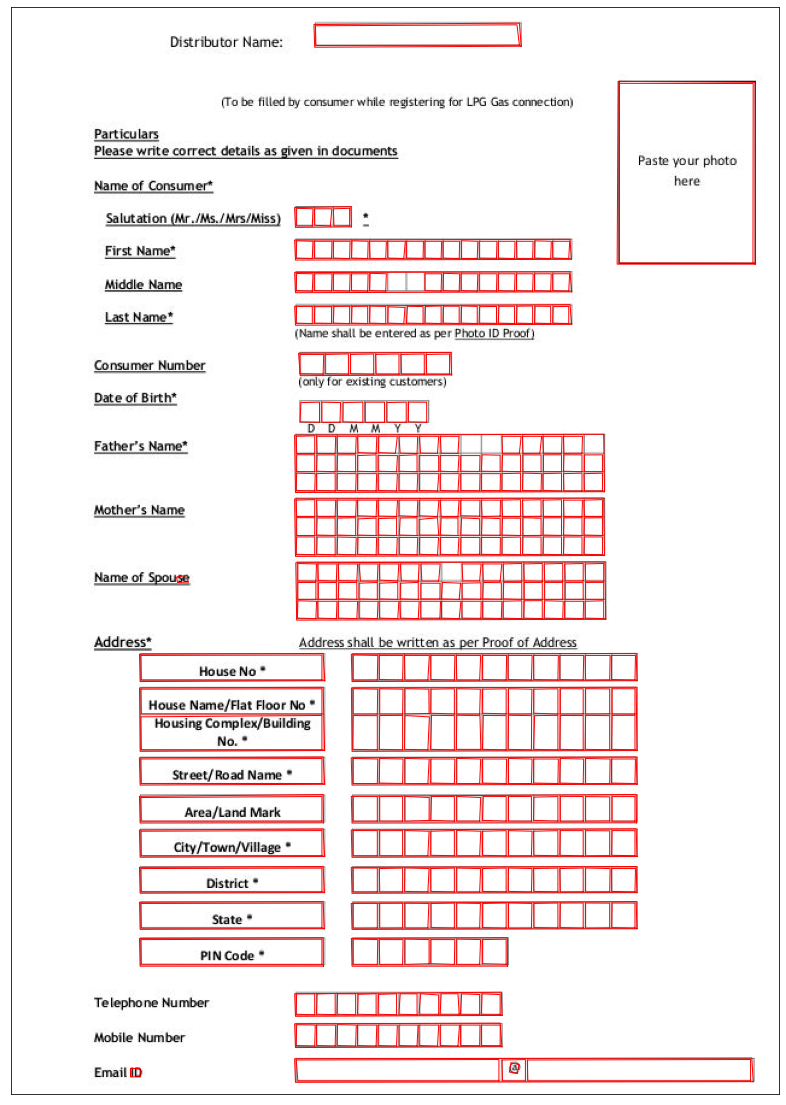

In [26]:
import numpy as np
import math

def angle_between_three_points(pointA, pointB, pointC):
    
    x1x2s = math.pow((pointA[0] - pointB[0]),2)
    x1x3s = math.pow((pointA[0] - pointC[0]),2)
    x2x3s = math.pow((pointB[0] - pointC[0]),2)
    
    y1y2s = math.pow((pointA[1] - pointB[1]),2)
    y1y3s = math.pow((pointA[1] - pointC[1]),2)
    y2y3s = math.pow((pointB[1] - pointC[1]),2)

    cosine_angle = np.arccos((x1x2s + y1y2s + x2x3s + y2y3s - x1x3s - y1y3s)/(2*math.sqrt(x1x2s + y1y2s)*math.sqrt(x2x3s + y2y3s)))

    return np.degrees(cosine_angle)


filtered_potential_squares = []

for coords in potential_squares:
    pointA = coords[0]
    pointB = coords[1]
    pointC = coords[2]
    angle1 = angle_between_three_points(pointA, pointB, pointC)
    
    pointA = coords[1]
    pointB = coords[2]
    pointC = coords[3]
    angle2 = angle_between_three_points(pointA, pointB, pointC)
    
    pointA = coords[2]
    pointB = coords[3]
    pointC = coords[0]
    angle3 = angle_between_three_points(pointA, pointB, pointC)
    
    pointA = coords[3]
    pointB = coords[0]
    pointC = coords[1]
    angle4 = angle_between_three_points(pointA, pointB, pointC)
    
    # print(np.std([angle1, angle2, angle3, angle4]))
    if np.std([angle1, angle2, angle3, angle4]) < 5:
        filtered_potential_squares.append(coords)
        
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(gray, cmap=plt.cm.gray)

for contour in filtered_potential_squares:
    ax.plot(contour[:, 1], contour[:, 0], '-r', linewidth=1)
        
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Filter 2 - I have a lot of rectangles here as well, can I get rid of them and only keep squares

The sides of the squares are the same , so if the deviation of the distances between the different sides is less, then its most likely a square

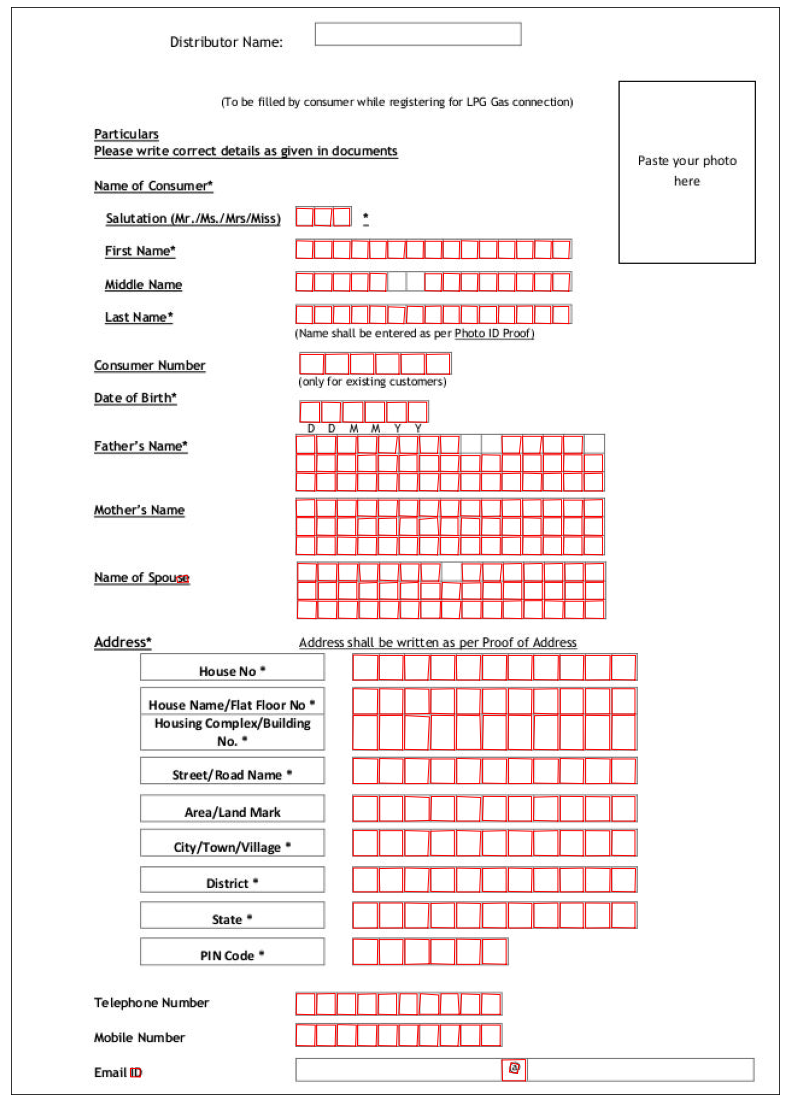

In [29]:
filtered2_potential_squares = []

def euclidean_distance(pointA, pointB):
    dist = np.linalg.norm(pointA-pointB)
    return dist
    
for coords in filtered_potential_squares:
    pointA = coords[0]
    pointB = coords[1]
    side1 = euclidean_distance(pointA, pointB)
    
    pointA = coords[1]
    pointB = coords[2]
    side2 = euclidean_distance(pointA, pointB)
    
    pointA = coords[2]
    pointB = coords[3]
    side3 = euclidean_distance(pointA, pointB)
    
    pointA = coords[3]
    pointB = coords[0]
    side4 = euclidean_distance(pointA, pointB)
    
    if np.std([side1, side2, side3, side4]) < 5:
        filtered2_potential_squares.append(coords)
    
    
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(gray, cmap=plt.cm.gray)

for contour in filtered2_potential_squares:
    ax.plot(contour[:, 1], contour[:, 0], '-r', linewidth=1)
        
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Ah! So cool!